I'll try to build a WR stat predictor in this notebook. First lets load our full database

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 
import math

In [4]:
import pandas as pd
import pickle

samples=pd.read_csv('TrainingSamples.csv')
samples.drop('Unnamed: 0', axis=1, inplace=True)

with open("stat_order.pickle",'rb') as f:
    stat_order=pickle.load(f)

Next, lets remove the first year of football data (since the averages will be bad) and extract all of the WR players

In [5]:
WRsamples=samples[(samples['Position']=="WR") & (samples['Week']>100)].reset_index(drop=True)

In [6]:
len(WRsamples)

1910

All of our lists got saved as strings in csv format, so lets convert them back to lists

In [7]:
all_lists = ['Opp Avg Stats','Opp Stat Std','Opp Avg Stats v Team','Opp Stat Std v Team',\
             'Opp Players','Player Avg Stats','Player Stat Std','Player Avg Stats v Opp',\
             'Player Stat Std v Opp','Team Avg Stats','Team Stat Std','Team Avg v Opp',\
             'Team Stat Std v Opp','Stat Outcome']

for list in all_lists:
    WRsamples[list] = WRsamples[list].apply(eval)

Next, lets remove any players that have "nan" stats

In [8]:
WRsamples['No Player Stats'] = WRsamples.apply(lambda x: math.isnan(x['Player Avg Stats'][0]), axis = 1)

In [9]:
WRsamples=WRsamples[WRsamples['No Player Stats']==False].reset_index(drop=True)

In [10]:
len(WRsamples)

1853

Now, let's calculate the fantasy points each player got in each sample incase we need to fall back to predicting points instead of stats.

In [11]:
WRsamples

,Player,Position,Inferred Position,Week,Games Benched,Is Benched,Team,TeamWL,TeamWL_v_opp,Teammates,...,Player Stat Std v Opp,Num Player Games v Opp,Team Avg Stats,Team Stat Std,Num Team Games,Team Avg v Opp,Team Stat Std v Opp,Num Team Games v Opp,Stat Outcome,No Player Stats
0,Albert Wilson,WR,WR,101.0,16.0,False,KC,"(11, 11)","(0, 1)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[202.5, 1.45454545455, 0.0, 0.409090909091, 12...","[82.4217259531, 1.30479091767, 0.0, 0.71726062...",22.0,"[154.0, 0.0, 0.0, 1.0, 142.0, 1.0, 0.0, 154.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.0, 5.0,...",False
1,Dwayne Bowe,WR,WR,101.0,2.0,False,KC,"(11, 11)","(0, 1)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[202.5, 1.45454545455, 0.0, 0.409090909091, 12...","[82.4217259531, 1.30479091767, 0.0, 0.71726062...",22.0,"[154.0, 0.0, 0.0, 1.0, 142.0, 1.0, 0.0, 154.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 6.0,...",False
2,Frankie Hammond,WR,WR,101.0,16.0,False,KC,"(11, 11)","(0, 1)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[202.5, 1.45454545455, 0.0, 0.409090909091, 12...","[82.4217259531, 1.30479091767, 0.0, 0.71726062...",22.0,"[154.0, 0.0, 0.0, 1.0, 142.0, 1.0, 0.0, 154.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
3,Jason Avant,WR,WR,101.0,2.0,False,KC,"(11, 11)","(0, 1)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.5,...",2.0,"[202.5, 1.45454545455, 0.0, 0.409090909091, 12...","[82.4217259531, 1.30479091767, 0.0, 0.71726062...",22.0,"[154.0, 0.0, 0.0, 1.0, 142.0, 1.0, 0.0, 154.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 4.0,...",False
4,Antonio Brown,WR,WR,101.0,0.0,False,PIT,"(15, 8)","(1, 0)","['Antonio Brown', 'Antwon Blake', 'Ben Roethli...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[291.608695652, 2.17391304348, 0.173913043478,...","[91.2687094008, 1.60575524458, 0.480233087704,...",23.0,"[157.0, 1.0, 0.0, 0.0, 95.0, 0.0, 0.0, 157.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.0, 7.0,...",False
5,Markus Wheaton,WR,WR,101.0,6.0,False,PIT,"(15, 8)","(1, 0)","['Antonio Brown', 'Antwon Blake', 'Ben Roethli...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[291.608695652, 2.17391304348, 0.173913043478,...","[91.2687094008, 1.60575524458, 0.480233087704,...",23.0,"[157.0, 1.0, 0.0, 0.0, 95.0, 0.0, 0.0, 157.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 2.0,...",False
6,Martavis Bryant,WR,WR,101.0,15.0,False,PIT,"(15, 8)","(1, 0)","['Antonio Brown', 'Antwon Blake', 'Ben Roethli...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[291.608695652, 2.17391304348, 0.173913043478,...","[91.2687094008, 1.60575524458, 0.480233087704,...",23.0,"[157.0, 1.0, 0.0, 0.0, 95.0, 0.0, 0.0, 157.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 44.0, 1.0,...",False
7,Davante Adams,WR,WR,101.0,10.0,False,GB,"(13, 10)","(0, 0)","['A.J. Hawk', 'Aaron Rodgers', 'Andrew Quarles...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[271.47826087, 1.95652173913, 0.0434782608696,...","[78.0974138442, 1.51738507536, 0.203931119992,...",23.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 2.0,...",False
8,Jordy Nelson,WR,WR,101.0,0.0,False,GB,"(13, 10)","(0, 0)","['A.J. Hawk', 'Aaron Rodgers', 'Andrew Quarles...",...,"[nan, nan, nan, 

In [13]:
point_dict={
    'passing_yds': 0.04,
    'passing_tds': 6,
    'passing_int': -2,
    'passing_twoptm': 2,
    'rushing_yds': 0.1,
    'rushing_tds': 6,
    'rushing_twoptm': 2,
    'receiving_yds': 0.1,
    'receiving_rec': 1,
    'receiving_tds': 6,
    'receiving_twoptm': 2,
    'kickret_tds': 6,
    'puntret_tds': 6,
    'fumbles_rec_tds': 6,
    'fumbles_lost': -2,
    'defense_int_tds': 6,
    'defense_frec_tds': 6,
    'defense_misc_tds': 6,
    'defense_sk': 1,
    'defense_puntblk': 2,
    'defense_fgblk': 2,
    'defense_xpblk': 2,
    'defense_int': 2,
    'defense_frec': 2,
    'defense_safe': 2,
    #No 2 pnt return data
    #No 1 pnt safety data
    #Need to figure out how to deal with defense points allowed and yds allowed
    'kicking_xpmade': 1,
    'kicking_fgmissed': -1,
    #Need to handle kicking yardage 
}

In [16]:
def CalcFantasyPoints(row):
    all_stats =  row['Stat Outcome']

    points = 0
    for stat in point_dict:
        points += all_stats[stat_order.index(stat)] * point_dict[stat]

    return points

In [19]:
WRsamples['FantasyPoints']=WRsamples.apply(CalcFantasyPoints,axis=1)

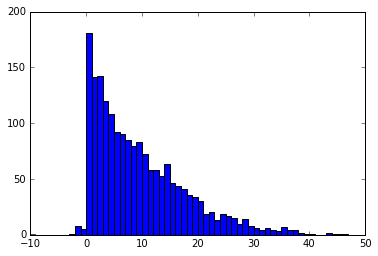

In [25]:
tarHist=np.hstack(WRsamples['FantasyPoints'].tolist())
plt.hist(tarHist, bins=range(-10,51,1))
plt.show()

For now also remove players with very low average targets as well

In [ ]:
'''
tarHist=np.hstack(WRsamples['Player Avg Stats'].apply(lambda x: x[stat_order.index('receiving_tar')]))
plt.hist(tarHist, bins='auto')
plt.show()
'''

In [ ]:
'''
WRsamples['High Receiving']=WRsamples['Player Avg Stats'].apply(lambda x: x[stat_order.index('receiving_tar')] > 4)
WRsamples=WRsamples[WRsamples['High Receiving']==True].reset_index(drop=True)
len(WRsamples)
'''

In [36]:
WRsamples[ (WRsamples['Team']=='KC') & (WRsamples['Player']=='Albert Wilson')]

,Player,Position,Inferred Position,Week,Games Benched,Is Benched,Team,TeamWL,TeamWL_v_opp,Teammates,...,Num Player Games v Opp,Team Avg Stats,Team Stat Std,Num Team Games,Team Avg v Opp,Team Stat Std v Opp,Num Team Games v Opp,Stat Outcome,No Player Stats,FantasyPoints
0,Albert Wilson,WR,WR,101.0,16.0,False,KC,"(11, 11)","(0, 1)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[202.5, 1.45454545455, 0.0, 0.409090909091, 12...","[82.4217259531, 1.30479091767, 0.0, 0.71726062...",22.0,"[154.0, 0.0, 0.0, 1.0, 142.0, 1.0, 0.0, 154.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.0, 5.0,...",False,13.7
166,Albert Wilson,WR,WR,102.0,15.0,False,KC,"(10, 12)","(1, 4)","['Albert Wilson', 'Allen Bailey', 'Cairo Santo...",...,1.0,"[211.272727273, 1.45454545455, 0.0, 0.40909090...","[83.8582038152, 1.30479091767, 0.0, 0.71726062...",22.0,"[229.4, 1.4, 0.0, 1.0, 128.6, 1.4, 0.0, 229.4,...","[39.7924615976, 1.01980390272, 0.0, 1.09544511...",5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.0
242,Albert Wilson,WR,WR,103.0,15.0,False,KC,"(11, 12)","(1, 0)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[208.913043478, 1.39130434783, 0.0, 0.39130434...","[82.7583769796, 1.31013210203, 0.0, 0.70643812...",23.0,"[240.0, 0.0, 0.0, 1.0, 126.0, 2.0, 0.0, 240.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 3.0,...",False,5.5
371,Albert Wilson,WR,WR,104.0,14.0,False,KC,"(12, 11)","(0, 6)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[209.217391304, 1.4347826087, 0.0, 0.391304347...","[82.8702267413, 1.3457206557, 0.0, 0.706438122...",23.0,"[185.333333333, 1.0, 0.0, 0.5, 119.666666667, ...","[83.8305168513, 1.0, 0.0, 0.5, 40.8642739919, ...",6.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.0
430,Albert Wilson,WR,WR,105.0,13.0,False,KC,"(12, 11)","(0, 0)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[204.739130435, 1.30434782609, 0.0, 0.43478260...","[80.9278892065, 1.33301823624, 0.0, 0.77043674...",23.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.0
743,Albert Wilson,WR,WR,108.0,12.0,False,KC,"(10, 13)","(0, 0)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[214.695652174, 1.08695652174, 0.0434782608696...","[76.0945834687, 1.05965718321, 0.203931119992,...",23.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 3.0,...",False,14.7
920,Albert Wilson,WR,WR,109.0,11.0,False,KC,"(10, 13)","(0, 2)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,1.0,"[226.956521739, 1.13043478261, 0.0434782608696...","[61.91050923, 1.03438063073, 0.203931119992, 0...",23.0,"[235.5, 0.0, 0.0, 0.5, 90.5, 0.5, 0.0, 235.5, ...","[81.5, 0.0, 0.0, 0.5, 51.5, 0.5, 0.0, 81.5, 10...",2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 3.0,...",False,10.1
987,Albert Wilson,WR,WR,110.0,10.0,False,KC,"(11, 12)","(0, 0)","['Albert Wilson', 'Alex Smith', 'Allen Bailey'...",...,0.0,"[229.173913043, 1.13043478261, 0.0434782608696...","[61.8185649433, 1.03438063073, 0.203931119992,...",23.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 3.0,...",False,4.2
1228,Albert Wilson,WR,WR,112.0,8.0,False,KC,"(12, 10)","(0, 7)","['Albert Wilson', 'Alex Smith', 'Anthony Sherm...",...,1.0,"[225.590909091, 1.22727272727, 0.0454545454545...","[64.8898781089, 1.04149447613, 0.208298895225,...",22.0,"[186.142857143, 0.857142857143, 0.0, 0.7142857...","[77.6373043093, 0.989743318611, 0.0, 0.6998542...",7.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 1.0,...",False,2.6
1345,Albert Wilson,WR,WR,113.0,7.0,False,KC,"(12, 10)","(2, 2)","['Albert Wilson', 'Alex Smith', 'Cair

# Examining feature correlations for receiving yards

We'll need to predict each WR stat separately.  The relevant scoring stats are:

* Receiving Yards
* Receptions
* TD receptions
* 2pt Receiving Conversion

Technically, we should try to predict rushing yards, punt return td, etc as well.. but these are good for a start.

Lets make some plots to see which features correlate with receving yards.  Here's a list of features that seem relevant:

* player average: receiving_yds
* player average: receiving_rec
* player average: receiving_tds
* player average: receiving_twoptm
* player average: receiving_tar
* player average: receiving_twopta
* player average: receiving_yac_yds
* team average: passing_yds
* team average: passing_tds
* team average: passing_twoptm
* team average: passing_int
* team average: passing_att
* team average: passing_cmp
* team average: passing_incmp
* team average: passing_cmp_air_yds
* team average: rushing_yds (maybe they pass less if they rush)
* team average: rushing_att
* opponent average: defense_sk
* opponent average: defense_int
* opponent average: defense_pass_def
* opponent average: defense_rushing_yds_allowed
* opponent average: defense_passing_yds_allowed
* opponent average: defense_rushing_tds_allowed
* opponent average: defense_passing_tds_allowed
* opponent average: defense_points_allowed
* Comparison: Team W/L to Opp W/L


This is a long list.. but it's worth looking at all of the correlations here.

In [26]:
def CalcCorr(x_stat_type,y_stat):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    for x_stat in stat_order:
        x_dfColumn = '%s Avg Stats' % x_stat_type

        all_x_stats =  WRsamples[x_dfColumn] 
        all_y_stats =  WRsamples['Stat Outcome'] 

        x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])
        y_stats = all_y_stats.apply(lambda x: x[stat_order.index(y_stat)])

        if abs(pearsonr(x_stats, y_stats)[0]) > 0.1:
            print x_stat_type, x_stat, "Correlation:", pearsonr(x_stats, y_stats)[0]


In [40]:
CalcCorr('Player','receiving_yds')
CalcCorr('Team','receiving_yds')    
CalcCorr('Opp','receiving_yds')

Player receiving_yds Correlation: 0.498959374128
Player receiving_rec Correlation: 0.482015510165
Player receiving_tds Correlation: 0.401040166199
Player receiving_twoptm Correlation: 0.127125245138
Player fumbles_rec_tds Correlation: 0.114262806868
Player receiving_tar Correlation: 0.47963272785
Player receiving_yac_yds Correlation: 0.42023676805


In [44]:
def CalcCorrPoints(x_stat_type):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    for x_stat in stat_order:
        x_dfColumn = '%s Avg Stats' % x_stat_type

        all_x_stats =  WRsamples[x_dfColumn] 
        y_stats =  WRsamples['FantasyPoints'] 

        x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])

        if abs(pearsonr(x_stats, y_stats)[0]) > 0.07:
            print x_stat_type, x_stat, "Correlation:", pearsonr(x_stats, y_stats)[0]


In [45]:
CalcCorrPoints('Player')
CalcCorrPoints('Team')    
CalcCorrPoints('Opp')

Player receiving_yds Correlation: 0.488934708377
Player receiving_rec Correlation: 0.487863657926
Player receiving_tds Correlation: 0.393176669556
Player receiving_twoptm Correlation: 0.13199323064
Player fumbles_rec_tds Correlation: 0.0964412615797
Player fumbles_lost Correlation: 0.0875706087591
Player passing_sk_yds Correlation: -0.0869073604162
Player receiving_tar Correlation: 0.47701335728
Player receiving_twopta Correlation: 0.0768183460948
Player receiving_yac_yds Correlation: 0.435725299187
Team passing_yds Correlation: 0.0741404018632
Team passing_tds Correlation: 0.0716453812676
Team passing_cmp_air_yds Correlation: 0.0853815990796
Team passing_sk_yds Correlation: 0.0817369456575
Team passing_twopta Correlation: 0.0769610098031
Team receiving_twopta Correlation: 0.0785292508673


It's pretty surprising that's there is no correlation between the opponent's passing yards allowed and the outcome of the player's receiving yards... Let's plot that to look into it a little further

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def PlotCorr(x_stat,x_stat_type,y_stat):
    #x_stat is a stat in stat_order, such as "receiving_yds"
    #x_stat_type is "Player" or "Team" or "Opp"
    x_dfColumn = '%s Avg Stats' % x_stat_type
    
    all_x_stats =  WRsamples[x_dfColumn] 
    all_y_stats =  WRsamples['Stat Outcome'] 

    x_stats = all_x_stats.apply(lambda x: x[stat_order.index(x_stat)])
    y_stats = all_y_stats.apply(lambda x: x[stat_order.index(y_stat)])

    xy = np.vstack([x_stats,y_stats])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_stats[idx], y_stats[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

In [ ]:
PlotCorr('defense_passing_yds_allowed','Opp','receiving_yds')

Interesting... there isn't a huge spread in the allowed passing yards of teams, and there really doesn't look like there's any correlation here.

In [ ]:
PlotCorr('passing_yds','Team','receiving_yds')

For team's passing yards, there are clearly two types of team... a high passing yards group and a low passing yards group.  Surprisingly, the high passing yards group doesn't seem to have higher yards for each player.  Instead, they must be passing to a wider range of players.

# Training a predictor

Okay, for now lets use the seven features that have abs(correlation) > 0.1 to training our predictor.  We might add more features based on our CV results later.

First, we need to split our sample into training, CV, and testing sets.  Let's randomly order our dataframe, using the same seed so that we get the same order every time we run this code.

In [46]:
np.random.seed(42)
WRsamples=WRsamples.reindex(np.random.permutation(WRsamples.index))
WRsamples.reset_index(inplace=True)

Now lets put half of the samples in training, a quarter in CV, and a quarter in test.

In [140]:
WR_training = WRsamples.ix[:round(len(WRsamples)/2)]
WR_cv = WRsamples.ix[round(len(WRsamples)/2): round(len(WRsamples)/2) + round(len(WRsamples)/4)]
WR_test = WRsamples.ix[round(len(WRsamples)/2) + round(len(WRsamples)/4):]

In [141]:
#WR_training['Discard']=WR_training['Stat Outcome'].apply(lambda x: x[stat_order.index('receiving_yds')]==0)
#WR_cv['Discard']=WR_cv['Stat Outcome'].apply(lambda x: x[stat_order.index('receiving_yds')]==0)

WR_training['Discard']= WR_training['FantasyPoints']==0
WR_cv['Discard']= WR_cv['FantasyPoints']==0




/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
WR_training=WR_training[WR_training['Discard']==False]
WR_cv=WR_cv[WR_cv['Discard']==False]

Now lets train a simple prediction model before trying anything fancy. First we'll try a linear regression model, then we'll try a nonlinear regression model, then we'll try a neural network.  As a reminder, here's the features that have a correlation with a player's receiving yard outcome

In [142]:
player_feats=['receiving_yds','receiving_rec','receiving_tar','receiving_yac_yds','fumbles_rec_tds','receiving_twoptm','fumbles_lost']
team_feats=[]
opp_feats=[]

all_feats=[player_feats,team_feats,opp_feats]

In [143]:
#Extract the features we want
def getFeats(row,feats):
    feat_df=pd.DataFrame()
    feat_list=[]
    
    #Player feats
    feat_list= [row['Player Avg Stats'][stat_order.index(feat)] for feat in feats[0]]

    #Team feats
    feat_list = feat_list + [row['Team Avg Stats'][stat_order.index(feat)] for feat in feats[1]]

    #Opponent feats
    feat_list = feat_list + [row['Opp Avg Stats'][stat_order.index(feat)] for feat in feats[2]]

    return feat_list

In [144]:
X_train=pd.DataFrame(WR_training.apply(getFeats,args=[all_feats],axis=1).tolist())
X_cv=pd.DataFrame(WR_cv.apply(getFeats,args=[all_feats],axis=1).tolist())

In [145]:
#Extract feature names for column names
def getFeatNames(feats):
    feat_names=[]
    
    for feat in feats[0]:
        feat_names = feat_names + ['player_%s' % feat]
    for feat in feats[1]:
        feat_names = feat_names + ['team_%s' % feat]
    for feat in feats[2]:
        feat_names = feat_names + ['opp_%s' % feat]
    
    return feat_names

In [146]:
X_train.columns=getFeatNames(all_feats)
X_cv.columns=getFeatNames(all_feats)
X_train.head()

,player_receiving_yds,player_receiving_rec,player_receiving_tar,player_receiving_yac_yds,player_fumbles_rec_tds,player_receiving_twoptm,player_fumbles_lost
0,35.714286,3.714286,5.642857,18.857143,0.0,0.0,0.071429
1,50.782609,3.086957,5.521739,11.086957,0.0,0.0,0.000000
2,27.500000,2.181818,3.909091,7.727273,0.0,0.0,0.000000
3,41.285714,2.619048,4.809524,10.714286,0.0,0.0,0.000000
4,40.142857,4.000000,5.928571,19.714286,0.0,0.0,0.071429


In [147]:
#Scale the features to help with fitting

#Get min and max of each feature in from the data set
def getExtremeOfFeat(feat,feat_type):
    #Player feats
    feat_list = WRsamples.apply(lambda x: x['%s Avg Stats' % feat_type][stat_order.index(feat)],axis=1).tolist()

    return (max(feat_list),min(feat_list))

def scaleFeat(featFrame,feats):
    
    #player feats
    for feat in feats[0]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Player')
        featFrame['player_%s' % feat]= (featFrame['player_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #team feats
    for feat in feats[1]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Team')
        featFrame['team_%s' % feat]= (featFrame['team_%s' % feat] - min_feat)/(max_feat-min_feat)
    
    #opp feats
    for feat in feats[2]:
        (max_feat,min_feat)=getExtremeOfFeat(feat,'Opp')
        featFrame['opp_%s' % feat]= (featFrame['opp_%s' % feat] - min_feat)/(max_feat-min_feat)
        
    return featFrame

In [148]:
scaleFeat(X_train,all_feats)
scaleFeat(X_cv,all_feats)
X_train.head()

,player_receiving_yds,player_receiving_rec,player_receiving_tar,player_receiving_yac_yds,player_fumbles_rec_tds,player_receiving_twoptm,player_fumbles_lost
0,0.329611,0.469622,0.434066,0.341518,0.0,0.0,0.071429
1,0.457901,0.390305,0.424749,0.220109,0.0,0.0,0.000000
2,0.259675,0.275862,0.300699,0.167614,0.0,0.0,0.000000
3,0.377046,0.331144,0.369963,0.214286,0.0,0.0,0.000000
4,0.367315,0.505747,0.456044,0.354911,0.0,0.0,0.071429


In [149]:
#Get outcome for the stat we are predicting
def getStatRes(row,stat):
    return row['Stat Outcome'][stat_order.index(stat)]

#Get outcome for the stat we are predicting
def getPointRes(row):
    return row['FantasyPoints']

In [150]:
#Y_train=WR_training.apply(getStatRes,args=['receiving_yds'],axis=1)
#Y_cv=WR_cv.apply(getStatRes,args=['receiving_yds'],axis=1)

Y_train=WR_training.apply(getPointRes,axis=1)
Y_cv=WR_cv.apply(getPointRes,axis=1)

MSE: 6.84195078342
Average Yardage: 8.29913793103
Correlation:  (0.41746425893683325, 5.4106773640436391e-21)


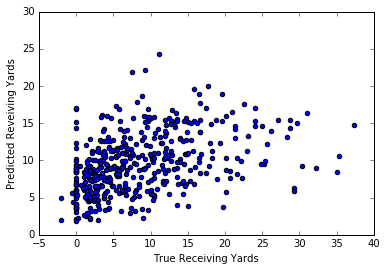

In [151]:
#Train a Linear regression model
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))

# Try Support Vector Regression

[LibSVM]MSE: 6.68770890407
Average Yardage: 8.29913793103
Correlation:  (0.42468821079926228, 9.6404291526180496e-22)


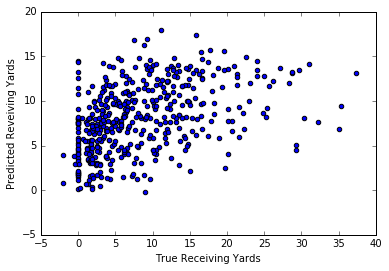

In [205]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
from sklearn import svm


lm=SVR(kernel='sigmoid', degree=1, gamma='auto', \
       coef0=0, tol=0.001, C=25.0, epsilon=0.1,\
       shrinking=True, cache_size=200, verbose=True, max_iter=-1)

lm.fit(X_train,Y_train)


#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))


# Try Bayesian Ridge Regression

Convergence after  6  iterations
MSE: 6.8057472226
Average Yardage: 8.29913793103
Correlation:  (0.42092407049685659, 2.3807377717895937e-21)


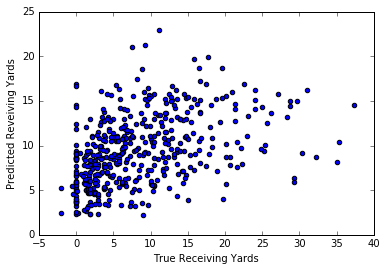

In [215]:
from sklearn.linear_model import BayesianRidge

lm = BayesianRidge(n_iter=500, tol=0.0001, alpha_1=1e-10, \
                    alpha_2=1e-12, lambda_1=1e-06, lambda_2=1e-06,\
                    compute_score=False, fit_intercept=True, normalize=False,\
                    copy_X=True, verbose=True)

lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")

#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))


# Try Elastic Net

MSE: 7.34158586368
Average Yardage: 8.29913793103
Correlation:  (0.42002880200767057, 2.9469102434760794e-21)


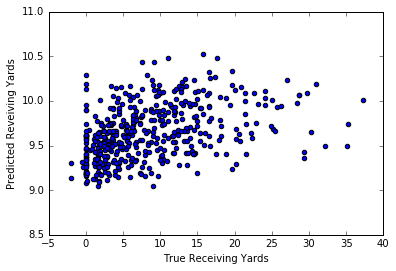

In [233]:
from sklearn.linear_model import ElasticNet

lm = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, \
                normalize=False, precompute=False, max_iter=10000,\
                copy_X=True, tol=0.001, warm_start=False, positive=False,\
                random_state=None, selection='cyclic')

lm.fit(X_train,Y_train)

#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Receiving Yards")
plt.ylabel("Predicted Reveiving Yards")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'MSE:', np.sqrt(mse)
print 'Average Yardage:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))

